Simulation for branching process with random mutation. Each time the pathogen transmits to a new person, it mutates. 

IN THIS VERSION, BOTH BETA AND GAMMA ARE ALLOWED TO MUTATE.

There are 2 main functions, "sim" and "recurrent_sim".

"sim" represents a process without recurrent spillover. It seeds the population with an initial case (presumably spilled over from a reservoir). It branches until either the infection goes extinct, or it surpasses a threshold. In the latter case, we call it an outbreak. 

"recurrent_sim" represents a process with random recurrent spillover, at some rate alpha. It begins with a single founding spillover case and then it branches. Meanwhile, recurrent spillovers arrive randomly, each giving birth to a new branching process. Overall the infection either surpasses an outbreak threshold, or it goes extinct (which requires a moment in time when ALL spillover processes have gone extinct). 

To dos & possible to dos: 
    - Make more graphs/visualizations.
    - Play with mutation rates.
    - Play with spillover rate.
    - Include backwards transmission.
    - Try it with a finite population.
    - Do a sanity check for the implementation of interevent time against Linda's slides.
    - Do a sanity check for the bulk recurrent simulation against the Voinson 2018 paper.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as sm

In [35]:
###################################################
# simulates infection WITHOUT recurrent spillover #
# ALLOWS BOTH BETA AND GAMMA TO MUTATE.           #
###################################################
#
# input beta0 is transmission rate of the initial case.
# input gamma0 is recovery rate of the initial case. 
#
# optional input mu_1 represents mutation rate for beta. If unspecified, defaults to 0.001
# optional input mu_2 represents mutation rate for gamma. If unspecified, defaults to 0.001
#
###################################################
#
# returns [0, t_ext] if extinction, where t_ext is time of extinction. 
# returns [1] if outbreak
#
###################################################
def sim(beta_0, gamma_0, mu_1=0.001, mu_2=0.001):
    
    outbreak_thresh = 100 #call it an outbreak if this many people are infected
    
    #store active cases as an array of triples
    #each triple looks like [beta, gamma, time of infection] and represents one infected person
    infecteds=[[beta_0, gamma_0, 0]]
    
    N_infected = len(infecteds) #keep track of number of infected people
    
    t_ext = None #time of extinction, will fill this value and return it if the infection goes extinct
    
    while True: 
        
        #print("\n", "infecteds now = ", infecteds)
        
        #keeps track of indices of recovered people
        #will delete them from array of infecteds at the end of each while loop iteration
        recovereds = []
        
        for i, person in enumerate(infecteds): #go through and branch each person in array of infecteds

            #print("\n", "branching person", i)
            
            [beta, gamma, t] = person
            
            while True:
                
                #interevent time
                #note this is interevent time for ONE person, NOT for entire population
                dt = np.random.exponential(scale=1/(beta + gamma))
                new_t = t + dt #time of new event
                
                #pick which new event happens, transmission or recovery         
                ev = np.random.rand() #draw number from uniform distribution over [0, 1)
                prob_trans = beta / (beta+gamma)

                if (ev < prob_trans): #transmission
                    
                    #print("person", i, " is transmitting")
                    
                    #pick beta for new case
                    mut1 = np.random.normal(loc=0.0, scale=mu_1) #mutation is a number drawn from normal distribution
                    new_beta = max(0, beta + mut1) #add mutation but don't allow negative beta
                    
                    #pick gamma for new case
                    mut2 = np.random.normal(loc=0.0, scale=mu_2) #mutation is a number drawn from normal distribution
                    new_gamma = max(0, gamma + mut2) #add mutation don't allow negative gamma
                    
                    #append new person to array of infecteds
                    infecteds = np.append(infecteds, [[new_beta, new_gamma, new_t]], axis=0)
                    N_infected += 1

                    #print("new infection: ", [new_beta, new_gamma, new_t])

                else: #recovery
                    
                    #print("person", i, " recovers") 
                    
                    N_infected -= 1
                    
                    if N_infected == 0:
                        t_ext = new_t #time of extinction
                    
                    #mark index of this recovered person, in order to delete them later
                    #(we don't delete yet, because that will mess up the indexing of the for loop)
                    recovereds.append(i)
                    break #skip to next person

        #after each time we complete a round of branching everybody:
        #1. update the array of infecteds by deleting recoveries
        infecteds = np.delete(infecteds, recovereds, axis=0)
        #2. check if we have extinction/outbreak yet
        if N_infected == 0:
            #print("\n", "extinction")
            return [0, t_ext]
        elif N_infected >= outbreak_thresh:
            #print("\n", "outbreak!")
            return [1]

In [36]:
#####################################################
# runs many simulations WITHOUT recurrent spillover #
#####################################################
#
# returns the percentage of those simulations that outbreak
#
#####################################################

def sim_percentage(beta_0, gamma_0, mu_1=0.001, mu_2=0.001):
    
    N_sims = 100 #number of simulations
    
    N_outbreaks = 0
    for i in range(N_sims):
        if sim(beta_0, gamma_0, mu_1, mu_2) == [1]: N_outbreaks += 1
    return N_outbreaks/N_sims

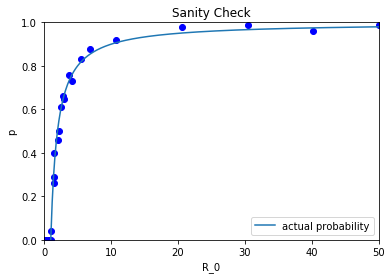

In [39]:
################
# SANITY CHECK #
################
#
# When there is no mutation, check that our simulation agrees with known results.
# From Linda's talk: the correct probability of outbreak is:
#
#                            0 if R_0 < 1
#                            1-1/R_0 = 1-gamma/beta if R_0 > 1
#
################

#Take a grid of gamma and beta values, which correspond to a variety of R_0 values.
beta_range = np.linspace(0.1, 5, 6)
gamma_range = np.linspace(0.1, 2, 4)

#scatter plot simulated percentages of outbreak
for beta in beta_range:
    for gamma in gamma_range:
        R_0 = beta/gamma
        p = sim_percentage(beta, gamma, mu_1=0, mu_2=0) #mutation rates are set to 0
        plt.plot(R_0, p, "ob")


#graph actual probability of outbreak
R_0 = np.arange(0.01,50,0.1)
plt.plot(R_0, 1-1/R_0, label='actual probability')

plt.title('Sanity Check')
plt.xlabel("R_0")
plt.ylabel("p")
plt.xlim(0, 50)
plt.ylim(0,1)
plt.legend()
plt.show()

Simulations WITH Recurrent Spillover

In [42]:
################################################
# simulates infection WITH recurrent spillover #
################################################
#
# input alpha = spillover rate.
#
# inputs beta_0, gamma_0, mu_1, mu_2 are the same as in the function sim from above
#
# there are two hidden inputs max_t_ext, t_s, which you should ignore. (do NOT pass in any values for these.)
# they are only used implicitly when this function recursively calls itself.
#
################################################
#
# returns 1 if outbreak
# returns 0 if extinction
#
################################################

def recurrent_sim(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001, max_t_ext=0, t_s=0): 
    
    #print("max_t_ext = ", max_t_ext)
    
    # hidden input max_t_ext keeps track of maximum extinction time seen so far
    # hidden input t_s keeps track of most recent time of spillover
    
    # simulate tree from a new spillover event
    sim_output = sim(beta_0, gamma_0, mu_1, mu_2)

    # if simulation outbreaks, we are done
    if sim_output == [1]:
        
        #print("\n", "outbreak!")
        return 1
    
    # otherwise, that tree goes extinct
    # but we need to check whether any other spillovers have happened
    else:
        
        #print("max_t_ext updating, = max of ", max_t_ext, "and", sim_output[1])
        max_t_ext = max(max_t_ext, sim_output[1]) #update max extinction time, if necessary
        
        #generate time of next spillover
        dt_s = np.random.exponential(scale=1/alpha) #inter-spillover time
        t_s += dt_s #time of next spillover
        #print("time of spillover is t_s = ", t_s)

        # if spillover occurs soon enough, we have to simulate another tree. recurse.
        if t_s < max_t_ext: 
            
            #print("a spillover occured! Recursing...")
            return recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2, max_t_ext, t_s)

        # if spillover occurs too late, we are done.
        else: 
            
            #print("next spillover too late. extinction!")
            return 0

In [43]:
####################################################
# run a single simulation WITH recurrent spillover #
####################################################

#parameters
alpha = 0.1
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim(alpha, beta_0, gamma_0)

0

In [44]:
##################################################
# runs many simulations WITH recurrent spillover #
##################################################
#
# returns the percentage of them that outbreak
#
##################################################

def recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1 = 0.01, mu_2 = 0.01): 
    
    N_sims = 10 #number of simulations
    
    N_outbreaks = 0
    for i in range(N_sims):
        if recurrent_sim(alpha, beta_0, gamma_0, mu_1, mu_2) == 1: 
                N_outbreaks += 1
    return N_outbreaks/N_sims

In [45]:
##################################################
# run a bulk simulation WITH recurrent spillover #
##################################################

#parameters
alpha = 0.7
beta_0 = 0.09
gamma_0 = 0.1

recurrent_sim_percentage(alpha, beta_0, gamma_0, mu_1=0.001, mu_2=0.001)

0.2